# Intrinsic dimension and density estimation LAB.6 Solutions

In this lab we implement two-NN algorithm and density estiamtions. First let's import all the useful modules.

In [15]:
import numpy as np # linear algebra
import numba as nb # linear algebra
import pandas as pd  # csv manipulation
from sklearn.preprocessing import OrdinalEncoder # for preprocessing
from scipy.spatial.distance import cdist # pairwise distances
from sklearn.decomposition import PCA  # for PCA comparison
import matplotlib.pyplot as plt # for plotting
from scipy.stats import norm, t #normal distribution, t distribution

## Exercise 1 

We start by downloading the dataset

In [2]:
# get the dataframe
df = pd.read_excel('../Datasets/Dry_Bean_Dataset.xlsx')

# create matrix for data in numpy ndarray
y = df['Class']
X = df.drop('Class', axis=1).values
encoder = OrdinalEncoder()
y = np.array(y)
encoder.fit(y.reshape(-1, 1))
y = encoder.transform(y.reshape(-1, 1))

# normilize
X = np.array(X - X.mean())/(X.std())

Let's now implement two-NN

In [3]:
def twoNN(X, fraction=0.8):

    from scipy.optimize import curve_fit

    # calculate pairwise distances
    dists = cdist(X, X, 'euclidean')

    # sort distances and get the first two neighboors
    r1, r2 = np.sort(dists, axis=-1)[:, 1:3].T

    # remove NaN or zero values
    idx = r1 > 0
    r1, r2 = r1[idx], r2[idx]

    # calculate mu
    mu = r2 / r1

    # compute empirical distribution F
    N_eff = int(mu.size * fraction)
    mu = np.sort(mu)[:N_eff]
    F = np.arange(start=1, stop=N_eff+1)/N_eff

    # fitting coordinates 
    idx_rem = (1. - F) > 0
    x = np.log(mu[idx_rem])
    y = -np.log(1. - F[idx_rem])

    def func(x, m):
        return m * x

    intrinsic_dim, _ = curve_fit(func, x, y)


    return float(intrinsic_dim)


Let's calculate the intrisic dimension

In [4]:
intrinsic_dim = twoNN(X)
print(f'Intrinsic dimension: {intrinsic_dim}')

Intrinsic dimension: 5.218060194403169


As a comparison, let's plot the eigenvalues of the PCA

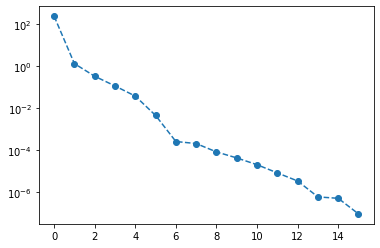

In [5]:
pca = PCA()
pca.fit(X)
plt.semilogy(range(len(pca.singular_values_)), pca.singular_values_, '--o')
plt.show()

We can see that also with PCA, it seems that the ID is around $5$. As evidenced by the elbow gap.

## Exercise 2

Let's start by creating the dataset

In [21]:
N = 100
X = np.concatenate(
    (np.random.standard_t(1, int(0.04*N))-3.5, 
     np.random.normal(5, 1, int(0.48 * N)), 
     np.random.normal(7.5, 1, int(0.48 * N)) 
     ))[:, np.newaxis]

### Histogram Density Estimation (Freedman Diaconis rule)

Let's compute the histograms for a different number of bins

In [22]:
def histogram_density(data, bins):

    # calculate the maximum and minimum
    max_ = np.max(data)
    min_ = np.min(data)

    # find the dividing intervals + centers + widths
    levels = np.linspace(min_, max_, num=bins+1)
    centers =  0.5*(levels[:-1] + levels[1:])
    widths =  (levels[:-1] - levels[1:])

    # calculate number of points falling in the levels
    n_points = np.array([np.sum(levels[i] <= X[X < levels[i+1]]) for i in range(bins)])
    assert n_points.size == centers.size

    # normalize probabilities
    probs = n_points / (sum(n_points) * bins)

    return probs, centers, widths
    

Let's plot it! We will use `ax.bar` where we can specify the centers, height (probability) and widths.

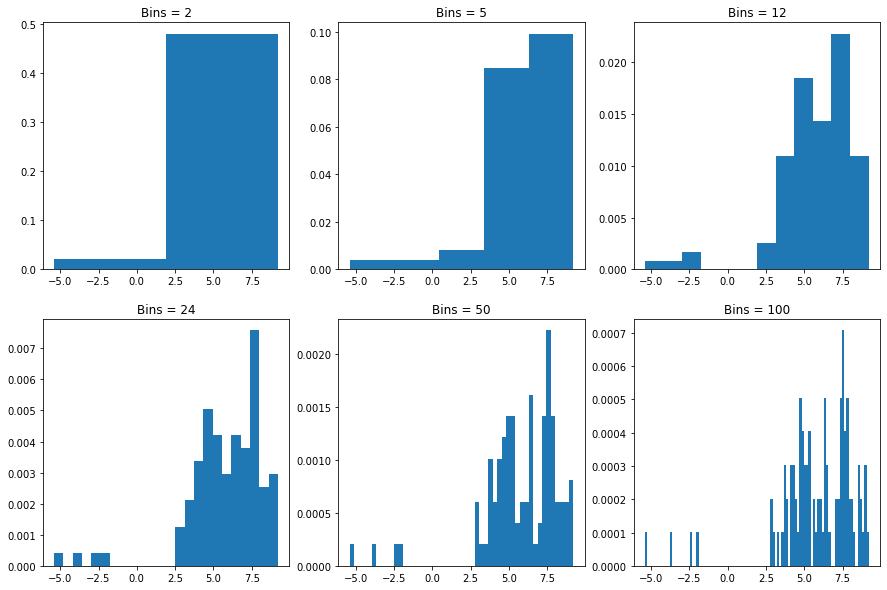

In [23]:
fig, axes = plt.subplots(2,3, figsize=(15,10))

for i, bin in enumerate([2,5,12,24,50,100]):
    ax = axes[i//3, i%3]
    probs, centers, widths = histogram_density(X, bins=bin)
    ax.bar(centers, probs, width=widths)
    ax.set_title(f"Bins = {bin}")
plt.show()

This is the to the matplotlib implementation `ax.hist`

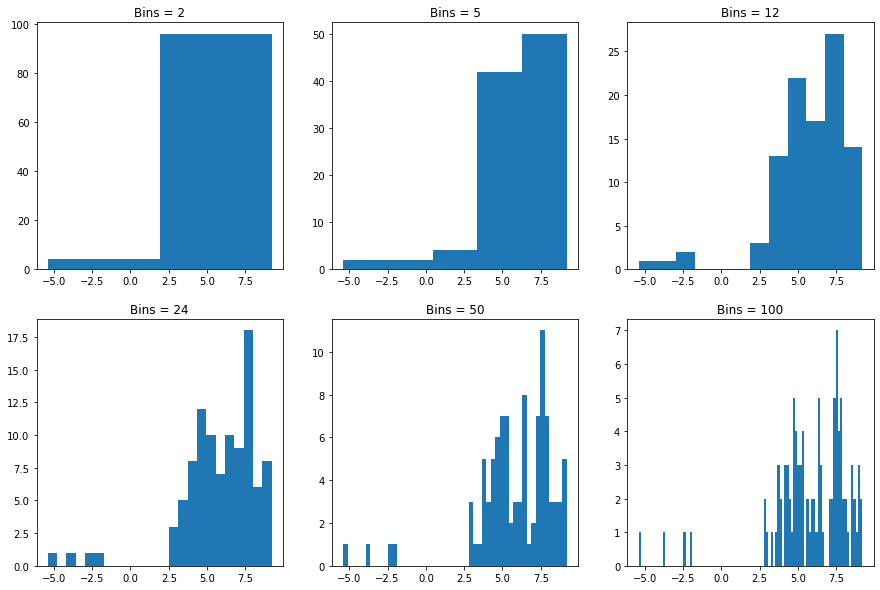

In [24]:
fig, axes = plt.subplots(2,3, figsize=(15,10))

for i, bin in enumerate([2,5,12,24,50,100]):
    ax = axes[i//3, i%3]
    ax.hist(X, bins=bin)
    ax.set_title(f"Bins = {bin}")
plt.show()

We now implement the Freedman Diaconis rule for chosing the optimal width

In [25]:
def friedman_diaconis_rule(data):
    q3, q1 = np.percentile(data, [75,25])
    iqr = q3 - q1
    return 2*iqr/(len(data)**(1/3))

Let's plot again the results using the friedman_diaconis_rule.

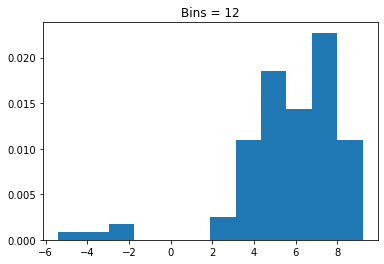

In [26]:
# number of bins
delta = friedman_diaconis_rule(X)
bin = int((np.max(X) - np.min(X))/delta)

# plotting
fig, ax = plt.subplots()
probs, centers, widths = histogram_density(X, bins=bin)
ax.bar(centers, probs, width=widths)
ax.set_title(f"Bins = {bin}")
plt.show()

### Kernel Density Estimation (Silverman's rule)

In [27]:
def gauss_kerneldensity(data, queries=None, std=1.):

    # compute query values (1000 pts)
    if queries is None:
        queries = np.linspace(data.min(),data.max(), 1000).reshape(-1, 1)

    # compute the square distance between the query points and the data
    dists = cdist(queries, data, 'sqeuclidean')

    # compute the kernel function
    function = np.exp( - 0.5 * dists / (std **2) )/np.sqrt(2 * np.pi * std **2)

    # normilize and return
    return function.sum(1) / len(data), queries.ravel()

Let's plot some results. The filled area represents the true distribution.

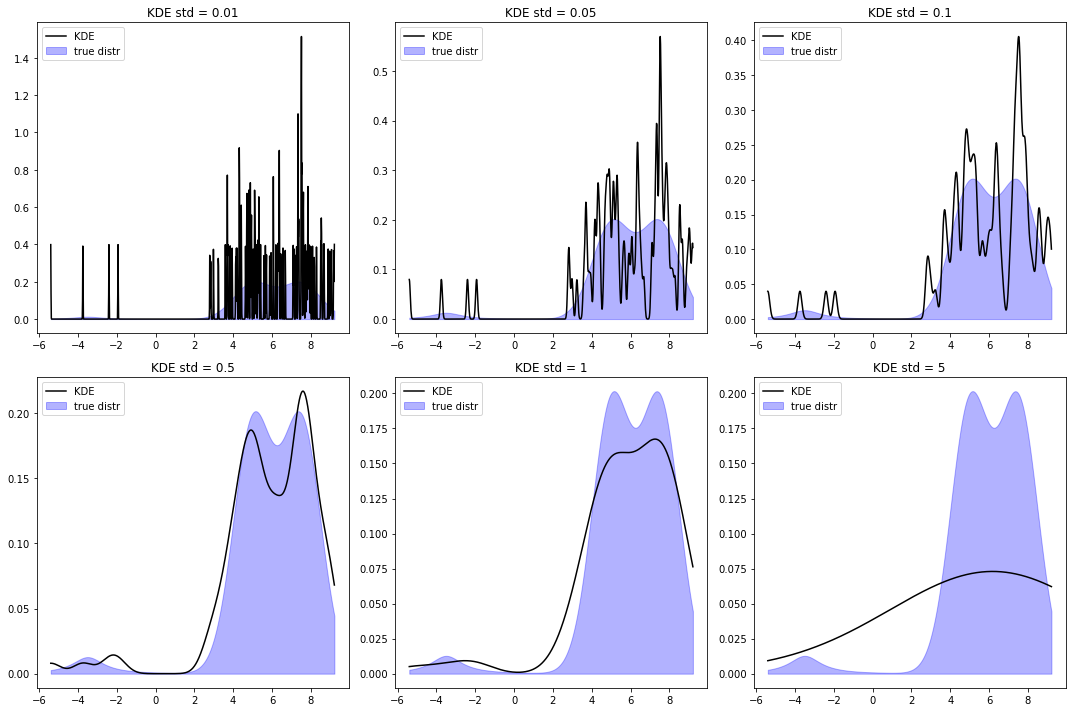

In [28]:
fig, axes = plt.subplots(2,3, figsize=(15,10))

for i, std in enumerate([0.01, 0.05, 0.1, 0.5, 1, 5]):
    ax = axes[i//3, i%3]
    y, x = gauss_kerneldensity(X, std=std)
    true_dens = 0.04* t(df=1,loc=-3.5).pdf(x) + 0.48* norm(5, 1).pdf(x) + 0.48*norm(7.5,1).pdf(x)
    ax.plot(x, y, label='KDE', color='k')
    ax.fill_between(x, true_dens, where=true_dens>=0, color='blue', alpha=0.3, label='true distr')
    ax.set_title(f"KDE std = {std}")
    ax.legend(loc=2)

plt.tight_layout()
plt.show()


Nice, as expected low values of `std` lead to poor estimates due to the sensitivity to noise. Let's now build the Silverman rule.

In [29]:
def silverman_rule(data):
    
    q3, q1 = np.percentile(data, [75,25])
    iqr = q3 - q1
    sigma = np.std(data)

    return 0.9*min(sigma, iqr/1.34)*len(data)**(-1/5)

We now see the result obtained using the Silverman rule:

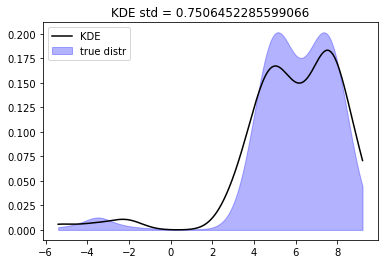

In [30]:
fig, ax = plt.subplots()

# calculate sigma
std = silverman_rule(X)

# plot
y, x = gauss_kerneldensity(X, std=std)
true_dens = 0.04* t(df=1,loc=-3.5).pdf(x) + 0.48* norm(5, 1).pdf(x) + 0.48*norm(7.5,1).pdf(x)
ax.plot(x, y, label='KDE', color='k')
ax.fill_between(x, true_dens, where=true_dens>=0, color='blue', alpha=0.3, label='true distr')
ax.set_title(f"KDE std = {std}")
ax.legend(loc=2)
plt.show()

Which is indeed a good approximation.